## Aplicación: Explorando dígitos escritos a mano

Para demostrar estos principios en un problema más interesante, consideremos una parte del problema histórico de reconocimiento óptico de caracteres (OCR, optical character recognition): la identificación de dígitos escritos a mano. 

En aplicaciones reales, este problema incluye tanto localizar como identificar caracteres en una imagen. Aquí tomaremos un atajo, y usaremos un dataset de dígitos preformateados que se incluyen en Scikit-Learn, evitandonos el trabajo extra que no es relevante en este momento.

### Cargamos y visualizamos los datos de dígitos

Usamos la interfaz de acceso a datos de Scikit-Learn y los observamos:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random as rn

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

Los datos de imágenes se almacenan como un array de tres dimensiones: 1797 muestras, cada una compuesta por una grilla de 8 x 8 píxeles (cada uno con tonos de grises).

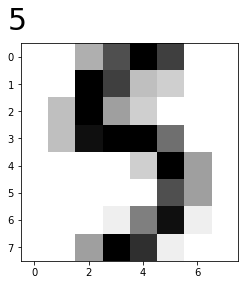

In [3]:
# Elegimos un dato al azar
posicion_dato = rn.randint(0, 1797)

imagen, numero = digits.images[posicion_dato], digits.target[posicion_dato]

# Inicializamos el gráfico de escalas de grises.
plt.imshow(imagen, cmap = 'binary')

# Imprimimos el número que se corresponde con la imagen.
plt.text(-1, -1, str(numero), size = 30);

Vamos a visualizar los primeros cien dígitos:

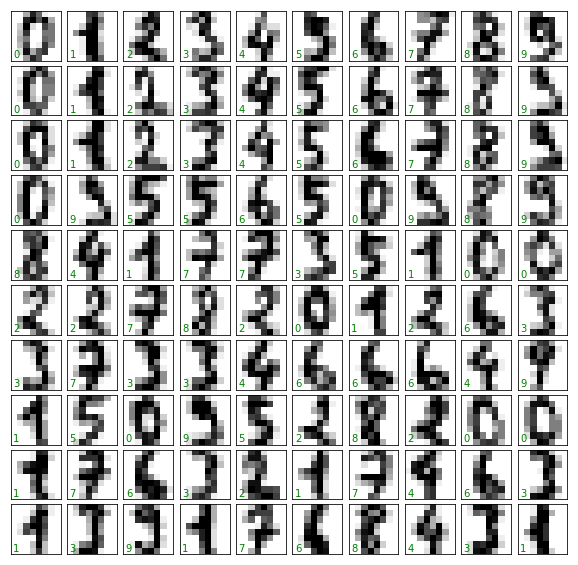

In [4]:
fig, axes = plt.subplots(10, 10, 
                         figsize     = (10, 10),
                         subplot_kw  = {'xticks':[], 'yticks':[]},
                         gridspec_kw = {'hspace': 0.1, 'wspace': 0.1} )

for i, ax in enumerate(axes.flat):
    
    ax.imshow(digits.images[i], 
              cmap = 'binary', 
              interpolation = 'nearest')
    
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform = ax.transAxes, color='green')

Para poder trabajar con estos datos en Scikit-learn, necesitamos una representación bidimensional de tamaño ``[n_samples, n_features]``. 
Podemos lograr esta transformación tratando cada píxel en la imagen como una feature distinta: es decir, estirando cada imagen-matriz para obtener un array unidimensional de longitud 64 píxeles que representa cada dígito. 

Adicionalmente, necesitamos el vector target, que nos da la etiqueta previamente determinada para cada dígito. 
Estas dos cantidades están incluidas en el dataset de prueba, bajo los atributos ``data`` y ``target``, respectivamente:

In [5]:
X = digits.data
X.shape

(1797, 64)

In [6]:
y = digits.target
y.shape

(1797,)

Aquí vemos que hay 1,797 muestras y 64 features.

### Aprendizaje no supervisado: Reducción de la dimensionalidad 

Nos gustaría visualizar nuestros puntos en el espacio de parámetros de 64 dimensiones, pero es muy difícil visualizar efectivamente puntos en un espacio de tan alta dimensionalidad. 
En cambio, vamos a reducir la dimensión a 2, usando un método no supervisado. 
Aquí, haremos uso del algoritmo llamado *Isomap* (del conjunto de algoritmos conocidos como manifold learning) y tranformaremos los datos a dos dimensiones:

In [7]:
from sklearn.manifold import Isomap

# inicializamos el objeto que contiene el reductor de dimensionalidad.
iso = Isomap(n_components=2)

# Entregamos los datos (vectores de 64 componentes), para que sean computados.
iso.fit(digits.data)
data_projected = iso.transform(digits.data)

data_projected.shape

(1797, 2)

Vemos que los datos proyectados ahora son bidimensionales.

Vamos a plotear estos datos para ver si podemos aprender algo de su estructura:

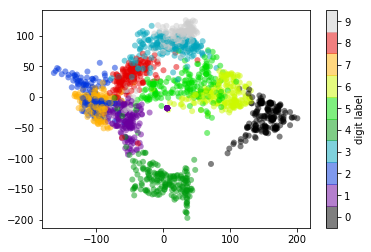

In [8]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], 
            c = digits.target,
            edgecolor='none', 
            alpha=0.5,
            cmap = plt.cm.get_cmap('nipy_spectral', 10) )

plt.colorbar(label = 'digit label', ticks = range(10) )

plt.clim(-0.5, 9.5);

Este plot nos dá cierta intuición sobre cuán bien se separan varios números en el espacio de parámetros de 64 dimensiones. 

Por ejemplo, los ceros (en negro) y los unos (en púrpura) tienen muy poco overlap en el espacio de parámetros. 

Intuitivamente, esto tiene sentido: un cero está vacío en el centro de la imagen, mientras un uno generalmente tendrá píxeles oscuros en el centro. 

Por otro lado, parece haber un espectro más o menos contínuo entre los 1 y los 4: podemos entender esto observando que algunas personas dibuja 1s con "sombreritos", lo cuál causa que se parezcan a 4s.  

En general, sin embargo, los diferentes grupos parecen estar relativamente bien separados en el espacio de parámetros: esto nos dice que incluso un algoritmo muy sencillo de clasificación podría performar correctamente sobre estos datos.
Vamos a intentarlo:

### Clasificación de dígitos

Vamos a aplicar un algoritmo de clasificación al dataset de dígitos. 

Como hicimos previamente con Iris, vamos a separar los datos en sets de training y testing, y ajustar un modelo de tipo Naive Bayes Gausiano:

In [9]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 0)


In [10]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

model.fit( Xtrain, ytrain )

y_model = model.predict(Xtest)

Ahora que hemos realizado la predicción, podemos validar su accuracy comparando los valores verdaderos del test set con las predicciones.

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.83333333333333337

Incluso con este modelo extremadamente simple, logramos más de %80 de accuracy para la clasificación de dígitos! 

Sin embargo, esta única métrica no nos dice *dónde* hemos cometido errores. Una forma de visualizar esto es usar la *matriz de confusión*, que podemos computar con Scikit-Learn y plotear con Seaborn:

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


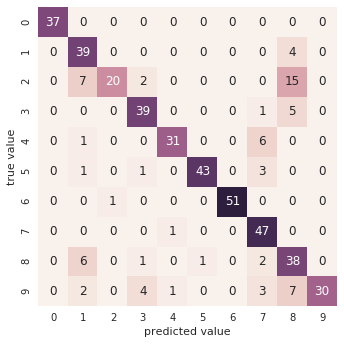

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=False)

plt.xlabel('predicted value')
plt.ylabel('true value');

Esto nos muestra dónde tienden a estar los puntos mal etiquetados: por ejemplo, un gran número de 2 son mal clasificados bien como 1s o como 8s. 

Otra forma de ganar intuición sobre las características del modelo es plotear los dígitos de entrada nuevamente, pero esta vez con las etiquetas predichas. 

Usaremos el color verde para las etiquetas correctas y rojo paras incorrectas:

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


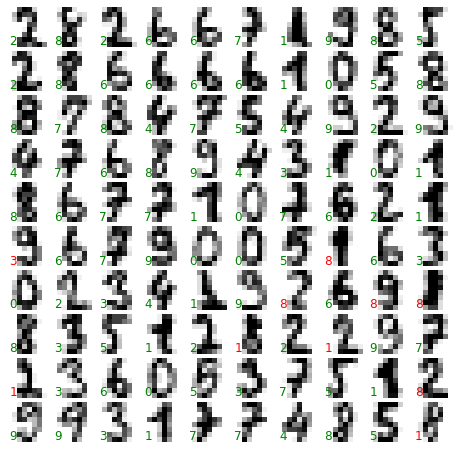

In [13]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw  = {'xticks':[], 'yticks':[]},
                         gridspec_kw = dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    
    ax.text(0.05, 0.05, str(y_model[i]),
            transform = ax.transAxes,
            color = 'green' if (ytest[i] == y_model[i]) else 'red')

Examinando este subset de los datos, podemos ganar cierto insight con respecto a dónde el algoritmo podría no estar performando óptimamente. 
Para ir más allá de nuestro %80 de ratio de clasificación, podríamos movernos a un algoritmo más sofisticado, como Support Vector Machines, Random Forests u otras técnicas  de clasificación.